# Tree Layout from Image

In this notebook, I share an approach for finding an optimal tree configuration when you only have an image at the start, along with an example for 28 trees. So if you decide to start from paper trees like the ones shown [here](https://www.kaggle.com/competitions/santa-2025/discussion/629770), or you find an interesting picture elsewhere, you can use this notebook to obtain the final tree configuration.

## Scoring functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext

import pandas as pd
from shapely import affinity, touches
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.strtree import STRtree

# Decimal precision and scaling factor
getcontext().prec = 25
scale_factor = Decimal('1e18')

class ParticipantVisibleError(Exception):
    pass

class ChristmasTree:
    """Represents a single, rotatable Christmas tree of a fixed size."""

    def __init__(self, center_x='0', center_y='0', angle='0'):
        """Initializes the Christmas tree with a specific position and rotation."""
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)
        scale_factor = Decimal('1e18')
        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h
        initial_polygon = Polygon(
            [
                # Start at Tip
                (Decimal('0.0') * scale_factor, tip_y * scale_factor),
                # Right side - Top Tier
                (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
                # Right side - Middle Tier
                (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
                # Right side - Bottom Tier
                (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
                # Right Trunk
                (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
                # Left Trunk
                (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Bottom Tier
                (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Middle Tier
                (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
                # Left side - Top Tier
                (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
            ]
        )
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))


def score(submission: pd.DataFrame) -> float:
    """
    For each n-tree configuration, the metric calculates the bounding square
    volume divided by n, summed across all configurations.

    This metric uses shapely v2.1.2.

    Examples
    -------
    >>> import pandas as pd
    >>> row_id_column_name = 'id'
    >>> data = [['002_0', 's-0.2', 's-0.3', 's335'], ['002_1', 's0.49', 's0.21', 's155']]
    >>> submission = pd.DataFrame(columns=['id', 'x', 'y', 'deg'], data=data)
    >>> solution = submission[['id']].copy()
    >>> score(solution, submission, row_id_column_name)
    0.877038143325...
    """
    scale_factor = Decimal('1e18')
    # remove the leading 's' from submissions
    data_cols = ['x', 'y', 'deg']
    submission = submission.astype(str)
    for c in data_cols:
        if not submission[c].str.startswith('s').all():
            raise ParticipantVisibleError(f'Value(s) in column {c} found without `s` prefix.')
        submission[c] = submission[c].str[1:]

    # enforce value limits
    limit = 100
    bad_x = (submission['x'].astype(float) < -limit).any() or \
            (submission['x'].astype(float) > limit).any()
    bad_y = (submission['y'].astype(float) < -limit).any() or \
            (submission['y'].astype(float) > limit).any()
    if bad_x or bad_y:
        raise ParticipantVisibleError('x and/or y values outside the bounds of -100 to 100.')

    # grouping puzzles to score
    submission['tree_count_group'] = submission['id'].str.split('_').str[0]

    total_score = Decimal('0.0')
    for group, df_group in submission.groupby('tree_count_group'):
        num_trees = len(df_group)

        # Create tree objects from the submission values
        placed_trees = []
        for _, row in df_group.iterrows():
#             print(row['x'], row['y'], row['deg'])
            placed_trees.append(ChristmasTree(row['x'], row['y'], row['deg']))

        # Check for collisions using neighborhood search
        all_polygons = [p.polygon for p in placed_trees]
        r_tree = STRtree(all_polygons)

        # Checking for collisions
        max_inter = 0
        for i, poly in enumerate(all_polygons):
            indices = r_tree.query(poly)
            for index in indices:
                if index == i:  # don't check against self
                    continue
                if poly.intersects(all_polygons[index]) and not poly.touches(all_polygons[index]):

                    print(poly)
                    raise ParticipantVisibleError(f'Overlapping trees in group {group}')

        # Calculate score for the group
        bounds = unary_union(all_polygons).bounds
        # Use the largest edge of the bounding rectangle to make a square boulding box
        side_length_scaled = max(bounds[2] - bounds[0], bounds[3] - bounds[1])

        group_score = (Decimal(side_length_scaled) ** 2) / (scale_factor**2) / Decimal(num_trees)
        total_score += group_score

    return float(total_score)

def draw(submission):
    scale_factor = Decimal('1e18')
    # remove the leading 's' from submissions
    data_cols = ['x', 'y', 'deg']
    submission = submission.astype(str)
    for c in data_cols:
        if not submission[c].str.startswith('s').all():
            raise ParticipantVisibleError(f'Value(s) in column {c} found without `s` prefix.')
        submission[c] = submission[c].str[1:]

    # enforce value limits
    limit = 100
    bad_x = (submission['x'].astype(float) < -limit).any() or \
            (submission['x'].astype(float) > limit).any()
    bad_y = (submission['y'].astype(float) < -limit).any() or \
            (submission['y'].astype(float) > limit).any()
    if bad_x or bad_y:
        raise ParticipantVisibleError('x and/or y values outside the bounds of -100 to 100.')

    # grouping puzzles to score
    submission['tree_count_group'] = submission['id'].str.split('_').str[0]

    total_score = Decimal('0.0')
    for group, df_group in submission.groupby('tree_count_group'):
        num_trees = len(df_group)

        # Create tree objects from the submission values
        placed_trees = []
        for _, row in df_group.iterrows():
#             print(row['x'], row['y'], row['deg'])
            placed_trees.append(ChristmasTree(row['x'], row['y'], row['deg']))

        # Check for collisions using neighborhood search
        all_polygons = [p.polygon for p in placed_trees]
        r_tree = STRtree(all_polygons)

        # Checking for collisions
        max_inter = 0
        for i, poly in enumerate(all_polygons):
            xx,yy = poly.exterior.xy
            plt.gca().set_aspect('equal')
            plt.plot(np.array(xx)/1e18,np.array(yy)/1e18)
            indices = r_tree.query(poly)
            for index in indices:
                if index == i:  # don't check against self
                    continue
                if poly.intersects(all_polygons[index]) and not poly.touches(all_polygons[index]):
                    max_inter = max(max_inter, poly.intersection(all_polygons[index]).area/2.4562499999999998e+35)
        print('Intersection = ', max_inter)

        # Calculate score for the group
        bounds = unary_union(all_polygons).bounds
        # Use the largest edge of the bounding rectangle to make a square boulding box
        side_length_scaled = max(bounds[2] - bounds[0], bounds[3] - bounds[1])
        print('Width = ', bounds[2] - bounds[0], 'Height = ', bounds[3] - bounds[1])
        group_score = (Decimal(side_length_scaled) ** 2) / (scale_factor**2) / Decimal(num_trees)
        total_score += group_score

    print('Score = ', float(total_score))

## Read the picture

I started with a configuration of 28 trees that I found [here](https://www.kaggle.com/competitions/santa-2025/discussion/666880). If you start from a photo of paper trees, it’s important to preprocess the image so that each tree has a different color. You can use a tool like the [Magic Wand](https://helpx.adobe.com/uk/photoshop/using/tool-techniques/magic-wand-tool.html) or something similar for this step.

Number of different colours: 14226


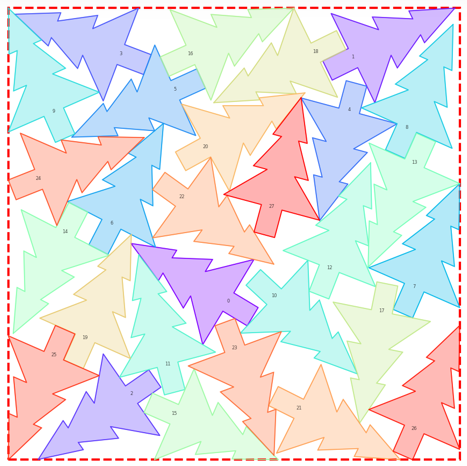

In [2]:
import cv2
import numpy as np

img = cv2.imread("/kaggle/input/santa2025-image/28.png")
h, w, _ = img.shape
colors = img.reshape(-1, 3)
unique_colors, labels = np.unique(colors, axis=0, return_inverse=True)
label_image = labels.reshape(h, w)
print("Number of different colours:", len(unique_colors))

from google.colab.patches import cv2_imshow
cv2_imshow(img)

## Identify trees colours

We can see that there are more than 14,000 different colors, but only a small subset of them is assigned to more than 100 pixels.

In [3]:
unique, counts = np.unique(colors, axis = 0, return_counts=True)
counts[counts > 100]

array([  247,   630,   145,   193,   146,   188,   163,   144,  3940,
         237,  3933,  3922,  3940,  3933,   143,  3944,  3946,   116,
        3950,   106,  3960,  3966,   113,  3970,   142,   303,  3690,
        4000,   110,   149,  3977,   209,  3954,   106,  3960,   119,
         191,  3962,   105,  3952,  3934,  3940,  3950,  3943,  3952,
        1037,  3956,  1528,  3867,   793,   173,  3964,  1898,  3945,
        3777, 54790])

In [4]:
np.sort(counts)[-60:]

array([   95,    97,    98,    98,   105,   106,   106,   110,   113,
         116,   119,   142,   143,   144,   145,   146,   149,   163,
         173,   188,   191,   193,   209,   237,   247,   303,   630,
         793,  1037,  1528,  1898,  3690,  3777,  3867,  3922,  3933,
        3933,  3934,  3940,  3940,  3940,  3943,  3944,  3945,  3946,
        3950,  3950,  3952,  3952,  3954,  3956,  3960,  3960,  3962,
        3964,  3966,  3970,  3977,  4000, 54790])

In most situations, the majority of pixels (96,869) are attributed to the background, while the next largest groups of pixels correspond to trees. Based on this, we need to set the **left_border** and **right_border** parameters to identify trees. In this case, these parameters are set to 5,000 and 10,000.

In [5]:
left_border = 3500
right_border = 10000


unique_colors1 = unique_colors[:,0].astype(int)+unique_colors[:,1].astype(int) * 1000 +unique_colors[:,2].astype(int) * 1000000
unique0 = unique[(counts > left_border) & (counts < right_border)]
unique1 = unique0[:,0].astype(int)+unique0[:,1].astype(int) * 1000 +unique0[:,2].astype(int) * 1000000
tree_labels = []
for colour1 in unique1:
  tree_labels.append(np.where(unique_colors1 == colour1)[0][0])
print("Number of trees =", len(tree_labels))


Number of trees = 28


## Find tops and bottoms of trees

Now we can compute the coordinates of the tops and bottoms of the trees. To do this, we calculate the line of symmetry for each group of pixels and project each pixel in the group onto this line.

In [6]:
tops = []
bottoms = []
for tree_label in tree_labels:
  tpl = np.where(label_image == tree_label)
  points = np.column_stack([tpl[0], tpl[1]]).astype(np.float64)
  mean = points.mean(axis=0)
  X = points - mean

  C = np.cov(X, rowvar=False)

  eigvals, eigvecs = np.linalg.eigh(C)

  axis = eigvecs[:, np.argmax(eigvals)]
  axis /= np.linalg.norm(axis)
  X = points - mean
  proj = X @ axis
  t_min = proj.min()
  t_max = proj.max()
  min_xy = mean + t_min * axis
  max_xy    = mean + t_max * axis
  if np.abs(t_max) > np.abs(t_min):
    tops.append(max_xy)
    bottoms.append(min_xy)
  else:
    tops.append(min_xy)
    bottoms.append(max_xy)

## Find the scale

Now it is possible to compute the average length of all trees in order to determine the image scale. It is important to inspect these lengths first and remove any obvious outliers, if present.

In [7]:
lens = []
for i in range(len(tops)):
  lens.append(np.sqrt(sum((tops[i]-bottoms[i])**2)))
lens

[378.6487421899325,
 132.89506333786994,
 133.6904718406263,
 133.4834689498719,
 133.44984643337122,
 134.61764126281906,
 134.16552980444104,
 134.23824637327826,
 133.20370605056706,
 134.21327448366227,
 133.3235786301877,
 125.26628962413129,
 132.37712755828056,
 132.87203953257224,
 133.41664003638454,
 135.0463925142188,
 137.56416010028838,
 134.18915066278598,
 130.7821373727304,
 133.11643587918132,
 132.09823874423225,
 132.90282494752344,
 133.69197105624662,
 133.40503944307113,
 132.10333093963374,
 134.2114339687816,
 132.23125219197723,
 125.5917037646124]

In [8]:
avg = np.mean(lens[-20:])
avg

132.58033637505343

## Find coordinates

Knowing the tops, bottoms, and scale, we can easily obtain the tree coordinates in the competition format. You can see that there are some intersections and orienation of one tree is incorrect which can be easily fixed using an interactive editor.

Intersection =  0.04961714180525614
Width =  3.3728934719135457e+18 Height =  3.367401789548799e+18
Score =  0.4063003704598933


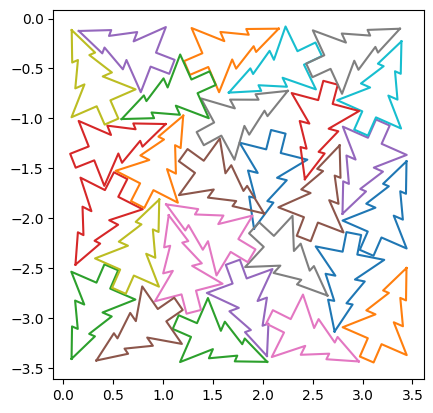

In [9]:
lens = []
group = str(len(tops)).zfill(3)
data = []
for i in range(len(tops)):
  diff = tops[i]-bottoms[i]
  centre = bottoms[i] + diff * 0.2
  if diff[0] == 0:
    diff[0] = 0.0000000001
  angle = np.arctan2(diff[1], diff[0]) / np.pi * 180+180
  centre_x = centre[1] / avg
  centre_y = -centre[0] / avg
  diff1 = [diff[1], -diff[0]]
  data.append([group + '_' + str(i), 's' + str(centre_x), 's' + str(centre_y), 's' + str(angle)])
draw(pd.DataFrame(columns=['id', 'x', 'y', 'deg'], data=data))

## Optimise the configuration

The previous image serves as the starting point for a bbox3-like optimization. After this optimization, we obtain an image like the one shown below.

Intersection =  0
Width =  3.187206728492882e+18 Height =  3.1872048581647145e+18
Score =  0.36279595464822495


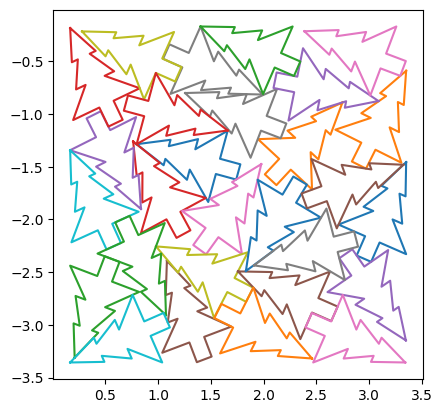

In [10]:
df_img = pd.read_csv('/kaggle/input/santa2025-image/28.csv')
draw(df_img)

In [11]:
df_all = pd.read_csv('/kaggle/input/eazy-optimizer/submission.csv')
score(df_all)

70.52451734462069

In [12]:
df_all.loc[df_all.id.str[:3] == '028'] = df_img.values
score(df_all)

70.52120808664982

In [13]:
df_all.to_csv('submission.csv', index=False)